# IMPORT LIBRARIES

In [1]:
# Suppressing Warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pickle
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score, classification_report, precision_score, recall_score, confusion_matrix, roc_curve, roc_auc_score 
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.preprocessing import MinMaxScaler
from wordcloud import WordCloud, STOPWORDS

import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

# READ INPUT FILES

In [3]:
reviews = pd.read_csv("sample30.csv")
reviews.head(3)

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive


In [4]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    30000 non-null  object
 1   brand                 30000 non-null  object
 2   categories            30000 non-null  object
 3   manufacturer          29859 non-null  object
 4   name                  30000 non-null  object
 5   reviews_date          29954 non-null  object
 6   reviews_didPurchase   15932 non-null  object
 7   reviews_doRecommend   27430 non-null  object
 8   reviews_rating        30000 non-null  int64 
 9   reviews_text          30000 non-null  object
 10  reviews_title         29810 non-null  object
 11  reviews_userCity      1929 non-null   object
 12  reviews_userProvince  170 non-null    object
 13  reviews_username      29937 non-null  object
 14  user_sentiment        29999 non-null  object
dtypes: int64(1), object(14)
memory usage

In [5]:
reviews.isnull().sum()

id                          0
brand                       0
categories                  0
manufacturer              141
name                        0
reviews_date               46
reviews_didPurchase     14068
reviews_doRecommend      2570
reviews_rating              0
reviews_text                0
reviews_title             190
reviews_userCity        28071
reviews_userProvince    29830
reviews_username           63
user_sentiment              1
dtype: int64

In [6]:
# dropping reviews_userCity, reviews_userProvince, categories, reviews_date,
# reviews_title as these columns are of no use in predicting the sentiment of a review
reviews = reviews.drop(["categories", "reviews_date", "reviews_title", "reviews_userCity", "reviews_userProvince"], axis = 1)

# dropping null values in reviews_username column, as this column is used as key column for recommending products
reviews = reviews.dropna(subset = ["reviews_username"])

In [7]:
!pip install wordcloud matplotlib
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

# EXPLORATORY DATA ANALYSIS

# Ratio of positive to negative sentiments

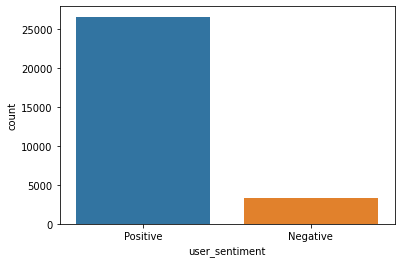

In [8]:
sns.countplot(data = reviews, x = reviews["user_sentiment"])
sns.set(style = 'darkgrid')
plt.show()

*Number of positive sentiments(88%) is much more higher than negative sentiments(11%). So class imbalance needs to be taken care*

# Frequently used words in review


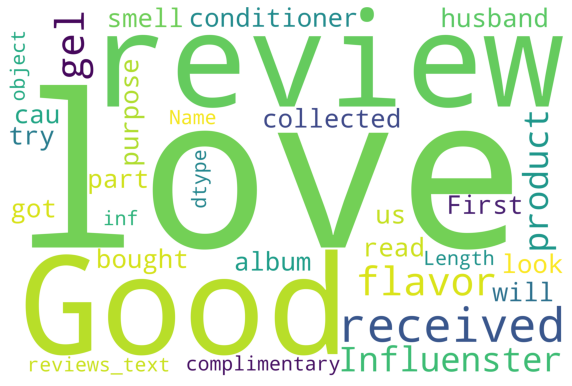

In [9]:
wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='white', \
                      collocations=False, stopwords = STOPWORDS).generate(str(reviews["reviews_text"]))
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud) 
plt.axis("off")
plt.show()

# Distribution of rating

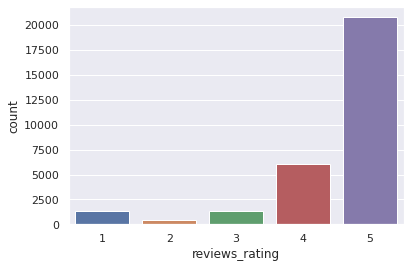

In [10]:
sns.countplot(data = reviews, x = 'reviews_rating')
plt.show()

*Most of the rating given to products by customers is 5 and least rating given is 2*

# Relationship b/w length of the review and rating

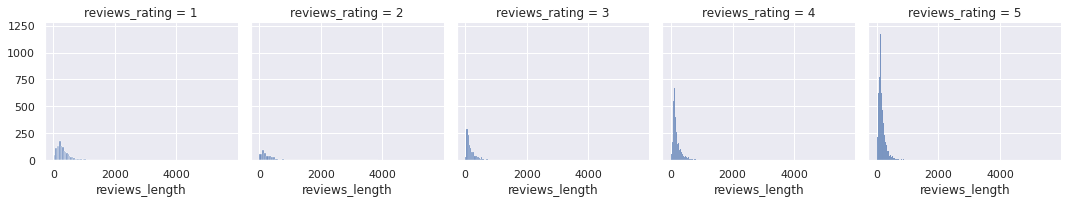

In [11]:
reviews["reviews_length"] = reviews["reviews_text"].apply(len)
sns.FacetGrid(reviews, col = 'reviews_rating').map(sns.histplot, 'reviews_length')
plt.show()

*The length of the review is higher for higher ratings and vice versa*

# Number of fake reviews


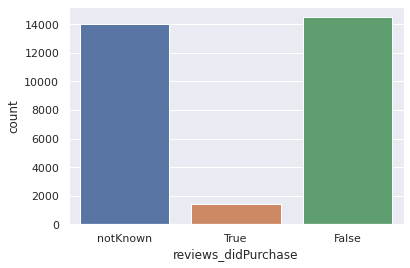

In [12]:
reviews["reviews_didPurchase"] = reviews["reviews_didPurchase"].fillna("notKnown")
sns.countplot(data = reviews, x = reviews["reviews_didPurchase"])
plt.show()

*Only 1434 customers has given true review. Around 14500 customers has given fake reviews.*

# TEXT PREPROCESSING

In [13]:
# selecting only 2 columns. reviews_text(x) and user_sentiment(y)
reviews_sentiment = reviews.loc[:, ("reviews_text", "user_sentiment", "name", "reviews_username", "reviews_rating")]

# mapping 1 for positive and 0 for negative
reviews_sentiment["user_sentiment"] = reviews["user_sentiment"].apply(lambda x:1 if x == 'Positive' else 0)
reviews_sentiment.head(5)

,reviews_text,user_sentiment,name,reviews_username,reviews_rating
0,i love this album. it's very good. more to the...,1,Pink Friday: Roman Reloaded Re-Up (w/dvd),joshua,5
1,Good flavor. This review was collected as part...,1,Lundberg Organic Cinnamon Toast Rice Cakes,dorothy w,5
2,Good flavor.,1,Lundberg Organic Cinnamon Toast Rice Cakes,dorothy w,5
3,I read through the reviews on here before look...,0,K-Y Love Sensuality Pleasure Gel,rebecca,1
4,My husband bought this gel for us. The gel cau...,0,K-Y Love Sensuality Pleasure Gel,walker557,1


# 1. Casing - Converting reviews to lower case

In [14]:
reviews_sentiment["reviews_text"] = reviews_sentiment["reviews_text"].apply(lambda x: x.lower())
reviews_sentiment.head()


,reviews_text,user_sentiment,name,reviews_username,reviews_rating
0,i love this album. it's very good. more to the...,1,Pink Friday: Roman Reloaded Re-Up (w/dvd),joshua,5
1,good flavor. this review was collected as part...,1,Lundberg Organic Cinnamon Toast Rice Cakes,dorothy w,5
2,good flavor.,1,Lundberg Organic Cinnamon Toast Rice Cakes,dorothy w,5
3,i read through the reviews on here before look...,0,K-Y Love Sensuality Pleasure Gel,rebecca,1
4,my husband bought this gel for us. the gel cau...,0,K-Y Love Sensuality Pleasure Gel,walker557,1


2. Removing Special Characters

# Removing Special Characters

In [15]:
reviews_sentiment["reviews_text"] = reviews_sentiment["reviews_text"].apply(lambda x: re.sub('[^A-Za-z0-9 ]+', '', x))
reviews_sentiment.head()

,reviews_text,user_sentiment,name,reviews_username,reviews_rating
0,i love this album its very good more to the hi...,1,Pink Friday: Roman Reloaded Re-Up (w/dvd),joshua,5
1,good flavor this review was collected as part ...,1,Lundberg Organic Cinnamon Toast Rice Cakes,dorothy w,5
2,good flavor,1,Lundberg Organic Cinnamon Toast Rice Cakes,dorothy w,5
3,i read through the reviews on here before look...,0,K-Y Love Sensuality Pleasure Gel,rebecca,1
4,my husband bought this gel for us the gel caus...,0,K-Y Love Sensuality Pleasure Gel,walker557,1


# Tokenization

In [16]:
reviews_sentiment["reviews_text"] = reviews_sentiment["reviews_text"].apply(lambda x:word_tokenize(x))
reviews_sentiment.head()

,reviews_text,user_sentiment,name,reviews_username,reviews_rating
0,"[i, love, this, album, its, very, good, more, ...",1,Pink Friday: Roman Reloaded Re-Up (w/dvd),joshua,5
1,"[good, flavor, this, review, was, collected, a...",1,Lundberg Organic Cinnamon Toast Rice Cakes,dorothy w,5
2,"[good, flavor]",1,Lundberg Organic Cinnamon Toast Rice Cakes,dorothy w,5
3,"[i, read, through, the, reviews, on, here, bef...",0,K-Y Love Sensuality Pleasure Gel,rebecca,1
4,"[my, husband, bought, this, gel, for, us, the,...",0,K-Y Love Sensuality Pleasure Gel,walker557,1


# Removing Stopwords

In [17]:
reviews_sentiment["reviews_text"] = reviews_sentiment["reviews_text"].apply(lambda words:[word for word in words if word not in stopwords.words("english")])
reviews_sentiment.head()

,reviews_text,user_sentiment,name,reviews_username,reviews_rating
0,"[love, album, good, hip, hop, side, current, p...",1,Pink Friday: Roman Reloaded Re-Up (w/dvd),joshua,5
1,"[good, flavor, review, collected, part, promot...",1,Lundberg Organic Cinnamon Toast Rice Cakes,dorothy w,5
2,"[good, flavor]",1,Lundberg Organic Cinnamon Toast Rice Cakes,dorothy w,5
3,"[read, reviews, looking, buying, one, couples,...",0,K-Y Love Sensuality Pleasure Gel,rebecca,1
4,"[husband, bought, gel, us, gel, caused, irrita...",0,K-Y Love Sensuality Pleasure Gel,walker557,1


In [18]:
## initialise the inbuilt Stemmer and the Lemmatizer
stemmer = PorterStemmer()
wordnet_lemmatizer = WordNetLemmatizer()

In [19]:
reviews_sentiment["reviews_text"] = reviews_sentiment["reviews_text"].apply(lambda words:[stemmer.stem(word) for word in words])
reviews_sentiment.head()

,reviews_text,user_sentiment,name,reviews_username,reviews_rating
0,"[love, album, good, hip, hop, side, current, p...",1,Pink Friday: Roman Reloaded Re-Up (w/dvd),joshua,5
1,"[good, flavor, review, collect, part, promot]",1,Lundberg Organic Cinnamon Toast Rice Cakes,dorothy w,5
2,"[good, flavor]",1,Lundberg Organic Cinnamon Toast Rice Cakes,dorothy w,5
3,"[read, review, look, buy, one, coupl, lubric, ...",0,K-Y Love Sensuality Pleasure Gel,rebecca,1
4,"[husband, bought, gel, us, gel, caus, irrit, f...",0,K-Y Love Sensuality Pleasure Gel,walker557,1


In [20]:
reviews_sentiment["reviews_text"] = reviews_sentiment["reviews_text"].apply(lambda words:[wordnet_lemmatizer.lemmatize(word, pos='v') for word in words])
reviews_sentiment.head()

,reviews_text,user_sentiment,name,reviews_username,reviews_rating
0,"[love, album, good, hip, hop, side, current, p...",1,Pink Friday: Roman Reloaded Re-Up (w/dvd),joshua,5
1,"[good, flavor, review, collect, part, promot]",1,Lundberg Organic Cinnamon Toast Rice Cakes,dorothy w,5
2,"[good, flavor]",1,Lundberg Organic Cinnamon Toast Rice Cakes,dorothy w,5
3,"[read, review, look, buy, one, coupl, lubric, ...",0,K-Y Love Sensuality Pleasure Gel,rebecca,1
4,"[husband, buy, gel, us, gel, caus, irrit, felt...",0,K-Y Love Sensuality Pleasure Gel,walker557,1


# joining words in list as sentence

In [21]:
reviews_sentiment["reviews_text"] = reviews_sentiment["reviews_text"].apply(lambda words:' '.join(words))
reviews_sentiment.head()

,reviews_text,user_sentiment,name,reviews_username,reviews_rating
0,love album good hip hop side current pop sound...,1,Pink Friday: Roman Reloaded Re-Up (w/dvd),joshua,5
1,good flavor review collect part promot,1,Lundberg Organic Cinnamon Toast Rice Cakes,dorothy w,5
2,good flavor,1,Lundberg Organic Cinnamon Toast Rice Cakes,dorothy w,5
3,read review look buy one coupl lubric ultim di...,0,K-Y Love Sensuality Pleasure Gel,rebecca,1
4,husband buy gel us gel caus irrit felt like bu...,0,K-Y Love Sensuality Pleasure Gel,walker557,1


In [22]:
reviews_sentiment.to_csv("Clean_data.csv")

# Splitting into train and test dataset

In [23]:
X = reviews_sentiment["reviews_text" ]
y = reviews_sentiment["user_sentiment"]

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 101)

In [25]:
X_train.shape, X_test.shape

((20955,), (8982,))

# Feature Extraction

In [26]:
vectorizer = TfidfVectorizer(max_features = 5000, analyzer = 'word')
tf_X_train = vectorizer.fit_transform(X_train).toarray()
tf_X_test = vectorizer.transform(X_test)

In [27]:
tf_X_train.shape, tf_X_test.shape

((20955, 5000), (8982, 5000))

# Handling Class Imbalance

In [28]:
print("count of class before smote")
print(Counter(y_train))
sm = SMOTE(random_state = 101)
X_train_sm, y_train_sm = sm.fit_sample(tf_X_train, y_train)

print("count of class before smote")
print(Counter(y_train_sm))

count of class before smote
Counter({1: 18627, 0: 2328})
count of class before smote
Counter({0: 18627, 1: 18627})


Model 1 : Logistic Regression

In [29]:
lr = LogisticRegression()
params = {'C' : [0.01, 0.1, 1, 10], 'penalty':['l1', 'l2'], 'class_weight' : ['balanced']}
# 4- fold cross validation
grid_search = GridSearchCV(lr, params, cv = 4, scoring = 'roc_auc', n_jobs = -1)
grid_search.fit(X_train_sm, y_train_sm)
model1 = grid_search.best_estimator_
model1.fit(X_train_sm, y_train_sm)

LogisticRegression(C=10, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [30]:
# Model 1 Evaluation
y_prob_test = model1.predict_proba(tf_X_test)
y_pred_test = model1.predict(tf_X_test)
print("Test Score")
print('-'*50)
print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred_test))
print('-'*50)
print(classification_report(y_test, y_pred_test))
print('-'*50)
print("AUC-ROC")
print(roc_auc_score(y_test, y_prob_test[:,1]))

FPR_model1, TPR_model1, Thresholds_model1 = roc_curve(y_test, y_prob_test[:,1])
AUC_ROC_model1 = roc_auc_score(y_test, y_prob_test[:,1])

Test Score
--------------------------------------------------
Confusion Matrix
[[ 802  228]
 [ 443 7509]]
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.64      0.78      0.71      1030
           1       0.97      0.94      0.96      7952

    accuracy                           0.93      8982
   macro avg       0.81      0.86      0.83      8982
weighted avg       0.93      0.93      0.93      8982

--------------------------------------------------
AUC-ROC
0.9551778510871052


# Model 2 : Naive Bayes

In [31]:
nb = MultinomialNB()
model2 = nb.fit(X_train_sm, y_train_sm)

In [32]:
# Model 2 Evaluation
y_prob_test = model2.predict_proba(tf_X_test)
y_pred_test = model2.predict(tf_X_test)
print("Test Score")
print('-'*50)
print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred_test))
print('-'*50)
print(classification_report(y_test, y_pred_test))
print('-'*50)
print("AUC-ROC")
print(roc_auc_score(y_test, y_prob_test[:,1]))

FPR_model2, TPR_model2, Thresholds_model2 = roc_curve(y_test, y_prob_test[:,1])
AUC_ROC_model2 = roc_auc_score(y_test, y_prob_test[:,1])

Test Score
--------------------------------------------------
Confusion Matrix
[[ 685  345]
 [1044 6908]]
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.40      0.67      0.50      1030
           1       0.95      0.87      0.91      7952

    accuracy                           0.85      8982
   macro avg       0.67      0.77      0.70      8982
weighted avg       0.89      0.85      0.86      8982

--------------------------------------------------
AUC-ROC
0.8702980626477311


# Model 3 : RandomForest

In [33]:
rf = RandomForestClassifier(random_state = 101)
params_rf = {'max_depth':[5, 10, 15], 
             'min_samples_leaf' : [5, 10, 15], 
             'n_estimators': [10,20,30]}

random_search = RandomizedSearchCV(rf, params_rf, cv = 4, n_jobs = -1, verbose = 1, scoring = 'roc_auc')
random_search.fit(X_train_sm, y_train_sm)
model3 = random_search.best_estimator_


Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  2.5min finished


In [34]:
# Model 3 Evaluation
y_prob_test = model3.predict_proba(tf_X_test)
y_pred_test = model3.predict(tf_X_test)
print("Test Score")
print('-'*50)
print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred_test))
print('-'*50)
print(classification_report(y_test, y_pred_test))
print('-'*50)
print("AUC-ROC")
print(roc_auc_score(y_test, y_prob_test[:,1]))

FPR_model3, TPR_model3, Thresholds_model3 = roc_curve(y_test, y_prob_test[:,1])
AUC_ROC_model3 = roc_auc_score(y_test, y_prob_test[:,1])

Test Score
--------------------------------------------------
Confusion Matrix
[[ 730  300]
 [1630 6322]]
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.31      0.71      0.43      1030
           1       0.95      0.80      0.87      7952

    accuracy                           0.79      8982
   macro avg       0.63      0.75      0.65      8982
weighted avg       0.88      0.79      0.82      8982

--------------------------------------------------
AUC-ROC
0.8410064147018032


# Comparing Logistic Regression, Naive Bayes, Random Forest Classifier models

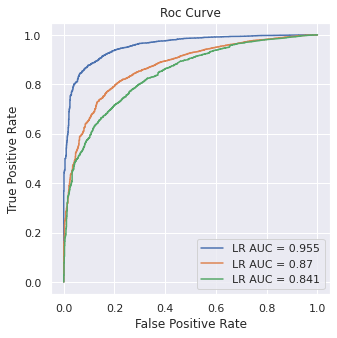

In [35]:
# ROC plot
plt.figure(figsize = (5,5))
plt.plot(FPR_model1, TPR_model1, label = f'LR AUC = {round(AUC_ROC_model1, 3)}' )
plt.plot(FPR_model2, TPR_model2, label = f'LR AUC = {round(AUC_ROC_model2, 3)}' )
plt.plot(FPR_model3, TPR_model3, label = f'LR AUC = {round(AUC_ROC_model3, 3)}' )
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc Curve')
plt.legend(loc = 'lower right')
plt.show()

Logistic Regression model is better than other models

# Saving models

In [36]:
# saving model as pickle file
with open("tfidf_model.pkl", 'wb') as file:
  pickle.dump(vectorizer, file)

with open("Logistic_regression_Model.pkl", 'wb') as file:
  pickle.dump(model1, file)

with open("df_clean_data.pkl", 'wb') as file:
  pickle.dump(reviews_sentiment, file)


# Building Recommendation System

In [37]:
# Creating Recommendation Dataframe
rec_df = reviews_sentiment[["reviews_username", "reviews_rating", "name"]]
rec_df.head()

,reviews_username,reviews_rating,name
0,joshua,5,Pink Friday: Roman Reloaded Re-Up (w/dvd)
1,dorothy w,5,Lundberg Organic Cinnamon Toast Rice Cakes
2,dorothy w,5,Lundberg Organic Cinnamon Toast Rice Cakes
3,rebecca,1,K-Y Love Sensuality Pleasure Gel
4,walker557,1,K-Y Love Sensuality Pleasure Gel


# Train - Test split

In [38]:
train, test = train_test_split(rec_df, test_size = 0.3, random_state = 101)

In [39]:
train.shape, test.shape

((20955, 3), (8982, 3))

In [40]:
# checking unique values in username and product name
print(train["reviews_username"].nunique())
print(train["name"].nunique())

18268
251


In [41]:
# creating matrix with products as columns and users as rows 
df_pivot = train.pivot_table(index = 'reviews_username', columns = 'name', values = 'reviews_rating')
df_pivot = df_pivot.fillna(0)
df_pivot.head()

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",Ambi Complexion Cleansing Bar,Annie's Homegrown Deluxe Elbows & Four Cheese Sauce,Annie's Homegrown Gluten Free Double Chocolate Chip Granola Bars,Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz",Avery174 11-1/4 X 9-1/4 Index Maker Extra Wide Label Dividers With 5 Tab - Clear (5 Sets Per Pack),"Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"BRIDGESTONE 130/70ZR18M/C(63W)FRONT EXEDRA G851, CRUISER RADL","Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium",Barielle Nail Rebuilding Protein,"Batherapy Natural Mineral Bath Sport Liquid, 16 oz",Baxter Of California Cream Pomade,"Beanitos Bean Chips, Simply Pinto Bean",Bedtime Originals Pinkie Musical Mobile,"Ben & Jerry's Coffee, Coffee Buzzbuzzbuzz! Ice Cream, Pint","Better Built 74010862 Bet74010862 60In Crossover Two Lid, Deep, Truck Tool Box",Bi-O-kleen Spray & Wipe All Purpose Cleaner,Bilbao Nightstand Gray Oak - South Shore,Bill Glor Gaither - Church In The Wildwood (cd),Bisquick Original Pancake And Baking Mix - 40oz,Black Front Loading Frame Set (8.5x11) Set Of 12,Black Sister's Revenge (dvd),Blue Anchor Design Throw Pillow (18x18) - Rizzy Home,Boraam Sonoma Kitchen Cart With Wire Brush Gray - Maaya Home,"Bounce Dryer Sheets, Fresh Linen, 160 sheets",Bumble Bee Solid White Albacore In Water - 5 Oz,"Burt's Bees Lip Shimmer, Raisin",...,Stacy's Simply Naked Bagel Chips,Stander Pt Bedcane - Bed Handle,Starbucks Iced Expresso Classics Vanilla Latte Coffee Beverage - 40oz,Starbucks153 Doubleshot Protein Coffee - 11 Fl Oz,Stargate (ws) (ultimate Edition) (director's Cut) (dvdvideo),"Storkcraft Tuscany Glider and Ottoman, Beige Cushions, Espresso Finish","Suave Professionals Hair Conditioner, Sleek","Super Poligrip Denture Adhesive Cream, Ultra Fresh - 2.4 Oz",Switchmas (dvd),Tai Pei Sweet & Sour Chicken,The Honest Company Laundry Detergent,The Resident Evil Collection 5 Discs (blu-Ray),The Script - No Sound Without Silence (cd),"The Seaweed Bath Co. Argan Conditioner, Smoothing Citrus",There's Something About Mary (dvd),Tim Holtz Retractable Craft Pick-Red 6x.5,Tostitos Bite Size Tortilla Chips,Tostitos Original Restaurant Style Tortilla Chips,Tostitos Simply Blue Corn Tortilla Chips,Toy Story Kids' Woody Accessory Kit,Tramontina Ceramica 10 Piece Cookware Set - Red,"Tree Hut Shea Body Butters, Coconut Lime, 7 oz",Trend Lab Park Nursing Cover - Paisley,Tresemme Kertatin Smooth Infusing Conditioning,Udi's Pepperoni Pizza,Various - Red Hot Blue:Tribute To Cole Porter (cd),Various Artists - Choo Choo Soul (cd),Vaseline Intensive Care Healthy Hands Stronger Nails,Vaseline Intensive Care Lip Therapy Cocoa Butter,"Vicks Vaporub, Regular, 3.53oz",Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Weleda Everon Lip Balm,Wilton Black Dots Standard Baking Cups,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00sab00

In [42]:
df_pivot.shape

(18268, 251)

In [43]:
# creating dummy train and test data to recommend products that are not seen by customers earlier
train_dummy = train.copy()

# products not rated by user is given as 1, else 0 
train_dummy["reviews_rating"]= train_dummy["reviews_rating"].apply(lambda x:1 if x==0 else 0)

# creating matrix with products as columns and users as rows 
df_pivot_dummy = train_dummy.pivot_table(index = 'reviews_username', columns = 'name', values = 'reviews_rating')
df_pivot_dummy = df_pivot_dummy.fillna(1)
df_pivot_dummy.head()

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",Ambi Complexion Cleansing Bar,Annie's Homegrown Deluxe Elbows & Four Cheese Sauce,Annie's Homegrown Gluten Free Double Chocolate Chip Granola Bars,Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz",Avery174 11-1/4 X 9-1/4 Index Maker Extra Wide Label Dividers With 5 Tab - Clear (5 Sets Per Pack),"Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"BRIDGESTONE 130/70ZR18M/C(63W)FRONT EXEDRA G851, CRUISER RADL","Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium",Barielle Nail Rebuilding Protein,"Batherapy Natural Mineral Bath Sport Liquid, 16 oz",Baxter Of California Cream Pomade,"Beanitos Bean Chips, Simply Pinto Bean",Bedtime Originals Pinkie Musical Mobile,"Ben & Jerry's Coffee, Coffee Buzzbuzzbuzz! Ice Cream, Pint","Better Built 74010862 Bet74010862 60In Crossover Two Lid, Deep, Truck Tool Box",Bi-O-kleen Spray & Wipe All Purpose Cleaner,Bilbao Nightstand Gray Oak - South Shore,Bill Glor Gaither - Church In The Wildwood (cd),Bisquick Original Pancake And Baking Mix - 40oz,Black Front Loading Frame Set (8.5x11) Set Of 12,Black Sister's Revenge (dvd),Blue Anchor Design Throw Pillow (18x18) - Rizzy Home,Boraam Sonoma Kitchen Cart With Wire Brush Gray - Maaya Home,"Bounce Dryer Sheets, Fresh Linen, 160 sheets",Bumble Bee Solid White Albacore In Water - 5 Oz,"Burt's Bees Lip Shimmer, Raisin",...,Stacy's Simply Naked Bagel Chips,Stander Pt Bedcane - Bed Handle,Starbucks Iced Expresso Classics Vanilla Latte Coffee Beverage - 40oz,Starbucks153 Doubleshot Protein Coffee - 11 Fl Oz,Stargate (ws) (ultimate Edition) (director's Cut) (dvdvideo),"Storkcraft Tuscany Glider and Ottoman, Beige Cushions, Espresso Finish","Suave Professionals Hair Conditioner, Sleek","Super Poligrip Denture Adhesive Cream, Ultra Fresh - 2.4 Oz",Switchmas (dvd),Tai Pei Sweet & Sour Chicken,The Honest Company Laundry Detergent,The Resident Evil Collection 5 Discs (blu-Ray),The Script - No Sound Without Silence (cd),"The Seaweed Bath Co. Argan Conditioner, Smoothing Citrus",There's Something About Mary (dvd),Tim Holtz Retractable Craft Pick-Red 6x.5,Tostitos Bite Size Tortilla Chips,Tostitos Original Restaurant Style Tortilla Chips,Tostitos Simply Blue Corn Tortilla Chips,Toy Story Kids' Woody Accessory Kit,Tramontina Ceramica 10 Piece Cookware Set - Red,"Tree Hut Shea Body Butters, Coconut Lime, 7 oz",Trend Lab Park Nursing Cover - Paisley,Tresemme Kertatin Smooth Infusing Conditioning,Udi's Pepperoni Pizza,Various - Red Hot Blue:Tribute To Cole Porter (cd),Various Artists - Choo Choo Soul (cd),Vaseline Intensive Care Healthy Hands Stronger Nails,Vaseline Intensive Care Lip Therapy Cocoa Butter,"Vicks Vaporub, Regular, 3.53oz",Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Weleda Everon Lip Balm,Wilton Black Dots Standard Baking Cups,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00sab00

In [44]:
df_pivot_dummy.shape

(18268, 251)

In [45]:
# similarity matrix
df_pivot = train.pivot_table(index = 'reviews_username', columns = 'name', values = 'reviews_rating')
df_pivot.head()

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",Ambi Complexion Cleansing Bar,Annie's Homegrown Deluxe Elbows & Four Cheese Sauce,Annie's Homegrown Gluten Free Double Chocolate Chip Granola Bars,Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz",Avery174 11-1/4 X 9-1/4 Index Maker Extra Wide Label Dividers With 5 Tab - Clear (5 Sets Per Pack),"Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"BRIDGESTONE 130/70ZR18M/C(63W)FRONT EXEDRA G851, CRUISER RADL","Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium",Barielle Nail Rebuilding Protein,"Batherapy Natural Mineral Bath Sport Liquid, 16 oz",Baxter Of California Cream Pomade,"Beanitos Bean Chips, Simply Pinto Bean",Bedtime Originals Pinkie Musical Mobile,"Ben & Jerry's Coffee, Coffee Buzzbuzzbuzz! Ice Cream, Pint","Better Built 74010862 Bet74010862 60In Crossover Two Lid, Deep, Truck Tool Box",Bi-O-kleen Spray & Wipe All Purpose Cleaner,Bilbao Nightstand Gray Oak - South Shore,Bill Glor Gaither - Church In The Wildwood (cd),Bisquick Original Pancake And Baking Mix - 40oz,Black Front Loading Frame Set (8.5x11) Set Of 12,Black Sister's Revenge (dvd),Blue Anchor Design Throw Pillow (18x18) - Rizzy Home,Boraam Sonoma Kitchen Cart With Wire Brush Gray - Maaya Home,"Bounce Dryer Sheets, Fresh Linen, 160 sheets",Bumble Bee Solid White Albacore In Water - 5 Oz,"Burt's Bees Lip Shimmer, Raisin",...,Stacy's Simply Naked Bagel Chips,Stander Pt Bedcane - Bed Handle,Starbucks Iced Expresso Classics Vanilla Latte Coffee Beverage - 40oz,Starbucks153 Doubleshot Protein Coffee - 11 Fl Oz,Stargate (ws) (ultimate Edition) (director's Cut) (dvdvideo),"Storkcraft Tuscany Glider and Ottoman, Beige Cushions, Espresso Finish","Suave Professionals Hair Conditioner, Sleek","Super Poligrip Denture Adhesive Cream, Ultra Fresh - 2.4 Oz",Switchmas (dvd),Tai Pei Sweet & Sour Chicken,The Honest Company Laundry Detergent,The Resident Evil Collection 5 Discs (blu-Ray),The Script - No Sound Without Silence (cd),"The Seaweed Bath Co. Argan Conditioner, Smoothing Citrus",There's Something About Mary (dvd),Tim Holtz Retractable Craft Pick-Red 6x.5,Tostitos Bite Size Tortilla Chips,Tostitos Original Restaurant Style Tortilla Chips,Tostitos Simply Blue Corn Tortilla Chips,Toy Story Kids' Woody Accessory Kit,Tramontina Ceramica 10 Piece Cookware Set - Red,"Tree Hut Shea Body Butters, Coconut Lime, 7 oz",Trend Lab Park Nursing Cover - Paisley,Tresemme Kertatin Smooth Infusing Conditioning,Udi's Pepperoni Pizza,Various - Red Hot Blue:Tribute To Cole Porter (cd),Various Artists - Choo Choo Soul (cd),Vaseline Intensive Care Healthy Hands Stronger Nails,Vaseline Intensive Care Lip Therapy Cocoa Butter,"Vicks Vaporub, Regular, 3.53oz",Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Weleda Everon Lip Balm,Wilton Black Dots Standard Baking Cups,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00sab00

In [46]:
# Normalising the rating of the movie for each user around 0 mean
mean = np.nanmean(df_pivot, axis = 1)
df_subtract = (df_pivot.T-mean).T
df_subtract.head()

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",Ambi Complexion Cleansing Bar,Annie's Homegrown Deluxe Elbows & Four Cheese Sauce,Annie's Homegrown Gluten Free Double Chocolate Chip Granola Bars,Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz",Avery174 11-1/4 X 9-1/4 Index Maker Extra Wide Label Dividers With 5 Tab - Clear (5 Sets Per Pack),"Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"BRIDGESTONE 130/70ZR18M/C(63W)FRONT EXEDRA G851, CRUISER RADL","Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium",Barielle Nail Rebuilding Protein,"Batherapy Natural Mineral Bath Sport Liquid, 16 oz",Baxter Of California Cream Pomade,"Beanitos Bean Chips, Simply Pinto Bean",Bedtime Originals Pinkie Musical Mobile,"Ben & Jerry's Coffee, Coffee Buzzbuzzbuzz! Ice Cream, Pint","Better Built 74010862 Bet74010862 60In Crossover Two Lid, Deep, Truck Tool Box",Bi-O-kleen Spray & Wipe All Purpose Cleaner,Bilbao Nightstand Gray Oak - South Shore,Bill Glor Gaither - Church In The Wildwood (cd),Bisquick Original Pancake And Baking Mix - 40oz,Black Front Loading Frame Set (8.5x11) Set Of 12,Black Sister's Revenge (dvd),Blue Anchor Design Throw Pillow (18x18) - Rizzy Home,Boraam Sonoma Kitchen Cart With Wire Brush Gray - Maaya Home,"Bounce Dryer Sheets, Fresh Linen, 160 sheets",Bumble Bee Solid White Albacore In Water - 5 Oz,"Burt's Bees Lip Shimmer, Raisin",...,Stacy's Simply Naked Bagel Chips,Stander Pt Bedcane - Bed Handle,Starbucks Iced Expresso Classics Vanilla Latte Coffee Beverage - 40oz,Starbucks153 Doubleshot Protein Coffee - 11 Fl Oz,Stargate (ws) (ultimate Edition) (director's Cut) (dvdvideo),"Storkcraft Tuscany Glider and Ottoman, Beige Cushions, Espresso Finish","Suave Professionals Hair Conditioner, Sleek","Super Poligrip Denture Adhesive Cream, Ultra Fresh - 2.4 Oz",Switchmas (dvd),Tai Pei Sweet & Sour Chicken,The Honest Company Laundry Detergent,The Resident Evil Collection 5 Discs (blu-Ray),The Script - No Sound Without Silence (cd),"The Seaweed Bath Co. Argan Conditioner, Smoothing Citrus",There's Something About Mary (dvd),Tim Holtz Retractable Craft Pick-Red 6x.5,Tostitos Bite Size Tortilla Chips,Tostitos Original Restaurant Style Tortilla Chips,Tostitos Simply Blue Corn Tortilla Chips,Toy Story Kids' Woody Accessory Kit,Tramontina Ceramica 10 Piece Cookware Set - Red,"Tree Hut Shea Body Butters, Coconut Lime, 7 oz",Trend Lab Park Nursing Cover - Paisley,Tresemme Kertatin Smooth Infusing Conditioning,Udi's Pepperoni Pizza,Various - Red Hot Blue:Tribute To Cole Porter (cd),Various Artists - Choo Choo Soul (cd),Vaseline Intensive Care Healthy Hands Stronger Nails,Vaseline Intensive Care Lip Therapy Cocoa Butter,"Vicks Vaporub, Regular, 3.53oz",Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Weleda Everon Lip Balm,Wilton Black Dots Standard Baking Cups,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00sab00

In [47]:
df_subtract.shape

(18268, 251)

In [48]:
# calculation pairwise distnce between users
user_corr = 1 - pairwise_distances(df_subtract.fillna(0), metric = 'cosine')
user_corr[np.isnan(user_corr)] = 0
user_corr

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

# Prediction

In [49]:
user_corr[user_corr < 0] = 0
user_corr

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

*Rating predicted is the weigted sum of correlation with the product rating*

In [50]:
user_rating_pred = np.dot(user_corr, df_pivot.fillna(0))
user_rating_pred

array([[0.        , 0.64168895, 0.        , ..., 5.61813683, 2.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [51]:
user_rating_pred.shape

(18268, 251)

In [52]:
# predicted rating of products
user_rating_final = np.multiply(user_rating_pred, df_pivot_dummy)
user_rating_final.head()

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",Ambi Complexion Cleansing Bar,Annie's Homegrown Deluxe Elbows & Four Cheese Sauce,Annie's Homegrown Gluten Free Double Chocolate Chip Granola Bars,Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz",Avery174 11-1/4 X 9-1/4 Index Maker Extra Wide Label Dividers With 5 Tab - Clear (5 Sets Per Pack),"Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"BRIDGESTONE 130/70ZR18M/C(63W)FRONT EXEDRA G851, CRUISER RADL","Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium",Barielle Nail Rebuilding Protein,"Batherapy Natural Mineral Bath Sport Liquid, 16 oz",Baxter Of California Cream Pomade,"Beanitos Bean Chips, Simply Pinto Bean",Bedtime Originals Pinkie Musical Mobile,"Ben & Jerry's Coffee, Coffee Buzzbuzzbuzz! Ice Cream, Pint","Better Built 74010862 Bet74010862 60In Crossover Two Lid, Deep, Truck Tool Box",Bi-O-kleen Spray & Wipe All Purpose Cleaner,Bilbao Nightstand Gray Oak - South Shore,Bill Glor Gaither - Church In The Wildwood (cd),Bisquick Original Pancake And Baking Mix - 40oz,Black Front Loading Frame Set (8.5x11) Set Of 12,Black Sister's Revenge (dvd),Blue Anchor Design Throw Pillow (18x18) - Rizzy Home,Boraam Sonoma Kitchen Cart With Wire Brush Gray - Maaya Home,"Bounce Dryer Sheets, Fresh Linen, 160 sheets",Bumble Bee Solid White Albacore In Water - 5 Oz,"Burt's Bees Lip Shimmer, Raisin",...,Stacy's Simply Naked Bagel Chips,Stander Pt Bedcane - Bed Handle,Starbucks Iced Expresso Classics Vanilla Latte Coffee Beverage - 40oz,Starbucks153 Doubleshot Protein Coffee - 11 Fl Oz,Stargate (ws) (ultimate Edition) (director's Cut) (dvdvideo),"Storkcraft Tuscany Glider and Ottoman, Beige Cushions, Espresso Finish","Suave Professionals Hair Conditioner, Sleek","Super Poligrip Denture Adhesive Cream, Ultra Fresh - 2.4 Oz",Switchmas (dvd),Tai Pei Sweet & Sour Chicken,The Honest Company Laundry Detergent,The Resident Evil Collection 5 Discs (blu-Ray),The Script - No Sound Without Silence (cd),"The Seaweed Bath Co. Argan Conditioner, Smoothing Citrus",There's Something About Mary (dvd),Tim Holtz Retractable Craft Pick-Red 6x.5,Tostitos Bite Size Tortilla Chips,Tostitos Original Restaurant Style Tortilla Chips,Tostitos Simply Blue Corn Tortilla Chips,Toy Story Kids' Woody Accessory Kit,Tramontina Ceramica 10 Piece Cookware Set - Red,"Tree Hut Shea Body Butters, Coconut Lime, 7 oz",Trend Lab Park Nursing Cover - Paisley,Tresemme Kertatin Smooth Infusing Conditioning,Udi's Pepperoni Pizza,Various - Red Hot Blue:Tribute To Cole Porter (cd),Various Artists - Choo Choo Soul (cd),Vaseline Intensive Care Healthy Hands Stronger Nails,Vaseline Intensive Care Lip Therapy Cocoa Butter,"Vicks Vaporub, Regular, 3.53oz",Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Weleda Everon Lip Balm,Wilton Black Dots Standard Baking Cups,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00sab00

# Top 20 Recommendation

In [53]:
# input -> reviews_username
# chekcing for one user
input = str('00sab00')

In [54]:
top_20_recommendation = user_rating_final.loc[input].sort_values(ascending = False)[:20]
top_20_recommendation

name
Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd                    46.380640
Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd)                27.688225
The Resident Evil Collection 5 Discs (blu-Ray)                                     20.556420
Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total                          10.132238
Red (special Edition) (dvdvideo)                                                    6.581813
Tostitos Bite Size Tortilla Chips                                                   5.631390
Windex Original Glass Cleaner Refill 67.6oz (2 Liter)                               5.618137
Jason Aldean - They Don't Know                                                      5.580857
Hormel Chili, No Beans                                                              5.478135
Burt's Bees Lip Shimmer, Raisin                                                     5.227393
Holmes174 Personal Indoor Heater W/ Manual Controls White 1500w H

# Evaluation

In [55]:
# fetching common users in train and test dataset
common_users = test[test["reviews_username"].isin(train["reviews_username"])]
common_users.head()

,reviews_username,reviews_rating,name
15102,marmar,5,Avery174 Ready Index Contemporary Table Of Con...
17991,asnyc,5,Vaseline Intensive Care Lip Therapy Cocoa Butter
8980,afwifey2003,5,Clorox Disinfecting Wipes Value Pack Scented 1...
19963,reenins,5,Clorox Disinfecting Bathroom Cleaner
22092,oldman,5,"Pleasant Hearth 7.5 Steel Grate, 30 5 Bar - Black"


In [56]:
common_users.shape

(2037, 3)

In [57]:
# creating matrix with users as rows and product as columns
common_user_pivot = common_users.pivot_table(index = 'reviews_username', columns = 'name', values = 'reviews_rating')
user_corr_df = pd.DataFrame(user_corr)

In [58]:
user_corr_df["User_Id"] = df_subtract.index
user_corr_df.set_index('User_Id', inplace = True)
user_corr_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,18228,18229,18230,18231,18232,18233,18234,18235,18236,18237,18238,18239,18240,18241,18242,18243,18244,18245,18246,18247,18248,18249,18250,18251,18252,18253,18254,18255,18256,18257,18258,18259,18260,18261,18262,18263,18264,18265,18266,18267
User_Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00sab00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01impala,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02dakota,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02deuce,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
06stidriver,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [59]:
common_users.head()

,reviews_username,reviews_rating,name
15102,marmar,5,Avery174 Ready Index Contemporary Table Of Con...
17991,asnyc,5,Vaseline Intensive Care Lip Therapy Cocoa Butter
8980,afwifey2003,5,Clorox Disinfecting Wipes Value Pack Scented 1...
19963,reenins,5,Clorox Disinfecting Bathroom Cleaner
22092,oldman,5,"Pleasant Hearth 7.5 Steel Grate, 30 5 Bar - Black"


In [60]:
users_list = common_users["reviews_username"].tolist()
user_corr_df.columns = df_subtract.index.tolist()
user_corr_df_1 = user_corr_df[user_corr_df.index.isin(users_list)]
user_corr_df_1.shape

(1711, 18268)

In [61]:
user_corr_df_2 = user_corr_df_1.T[user_corr_df_1.T.index.isin(users_list)]
user_corr_df_3 = user_corr_df_2.T
user_corr_df_3.head()

,1234,1234567,1234asdf,1943,1witch,23jen,37f5p,4cloroxl,7.87E+11,7inthenest,85lisa,8ellie24,aalyah,aaron,abbi,abc,abcssds,abigail,ac94,ace24,acellacey,acjuarez08,acv4217,adam,adamsmom,adizzione,adriana,adriana9999,ael26,afooey,afwifey2003,agmt,ahjohnson1983,aisha,ajay,ajeff,ajune,alarm,alex,alex5514,...,voxemluth,vreal88,walker,wally,wally123,want297z,watson28,wcgirl,weewee,wendy,wendy59,wernigcourtney,whythis,wildman,willy,wind,windowkitty,winniepoo2,wolfie,wolvarine,wolverine,woody,woohoo,woowoo,wowiezowie,wownostreaks,wren113,xavier,xcoupon,xmom,xstr8edgex,yamel97,yoadrian,yshan,yucky111,yummy,yvonne,zapman,zitro,zmom
User_Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1234,1.000000,0.0,0.0,0.288675,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.288675,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1234567,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1234asdf,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1943,0.288675,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.577350,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.080978,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.288675,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1witch,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [62]:
user_corr_df_3.shape

(1711, 1711)

In [63]:
user_corr_df_3[user_corr_df_3<0] = 0
common_users_rating_pred = np.dot(user_corr_df_3, common_user_pivot.fillna(0))
common_users_rating_pred

array([[1.66666667, 3.20936387, 0.        , ..., 0.        , 0.82500498,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [64]:
test_dummy = common_users.copy()
test_dummy["reviews_rating"] = test_dummy["reviews_rating"].apply(lambda x: 1 if x>= 1 else 0)
test_dummy = test_dummy.pivot_table(index = 'reviews_username', columns = "name", values = "reviews_rating").fillna(0)

In [65]:
common_user_rating_pred = np.multiply(common_users_rating_pred, test_dummy)
common_user_rating_pred.head()

name,100:Complete First Season (blu-Ray),Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",Ambi Complexion Cleansing Bar,Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz","Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium","Beanitos Bean Chips, Simply Pinto Bean","Ben & Jerry's Coffee, Coffee Buzzbuzzbuzz! Ice Cream, Pint",Bi-O-kleen Spray & Wipe All Purpose Cleaner,Bilbao Nightstand Gray Oak - South Shore,Bisquick Original Pancake And Baking Mix - 40oz,Boraam Sonoma Kitchen Cart With Wire Brush Gray - Maaya Home,"Bounce Dryer Sheets, Fresh Linen, 160 sheets","Burt's Bees Lip Shimmer, Raisin",Cantu Coconut Milk Shine Hold Mist - 8oz,"Caress Moisturizing Body Bar Natural Silk, 4.75oz",Cars Toon: Mater's Tall Tales,CeraVe SA Renewing Cream,Cheetos Crunchy Flamin' Hot Cheese Flavored Snacks,Chester's Cheese Flavored Puffcorn Snacks,Chex Muddy Buddies Brownie Supreme Snack Mix,Chips Ahoy! Original Chocolate Chip - Cookies - Family Size 18.2oz,Chobani174 Strawberry On The Bottom Non-Fat Greek Yogurt - 5.3oz,Clear Scalp & Hair Therapy Total Care Nourishing Shampoo,Clorox Disinfecting Bathroom Cleaner,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,"Coty Airspun Face Powder, Translucent Extra Coverage",Cuisinart174 Electric Juicer - Stainless Steel Cje-1000,Dark Shadows (includes Digital Copy) (ultraviolet) (dvdvideo),Delta Single Handle Shower Faucet,Diet Canada Dry Ginger Ale - 12pk/12 Fl Oz Cans,Doc Mcstuffins: Friendship Is The Best Medicine,Equals (blu-Ray),"Finish Quantum Dishwasher Detergent, Lemon Sparkle Scent, 45 Count",Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,...,"Pleasant Hearth 7.5 Steel Grate, 30 5 Bar - Black",Pleasant Hearth Diamond Fireplace Screen - Espresso,Post Bound Jumbo Album - Burgundy (11x14),Power Crunch Protein Energy Bar Peanut Butter Creme Original,Queen Helene Cocoa Butter Solid,Ragu Roasted Garlic Parmesan Pasta Sauce,Ragu Traditional Pasta Sauce,Red (special Edition) (dvdvideo),SC Johnson One Step No Buff Wax,Sabre 2 Pack Door And Window Alarm,"Shea Moisture Mango & Carrot Kids Extra-Nourishing Conditioner, 8fl Oz","Smead174 Recycled Letter Size Manila File Backs W/prong Fasteners, 2 Capacity, 100/box",Solo Foods Poppy Seed Cake and Pastry Filling,Soothing Touch Lemon Cardamom Vegan Lip Balm .25 Oz,Sopranos:Season 6 Part 1 (blu-Ray),Stacy's Simply Naked Bagel Chips,Stander Pt Bedcane - Bed Handle,Stargate (ws) (ultimate Edition) (director's Cut) (dvdvideo),"Storkcraft Tuscany Glider and Ottoman, Beige Cushions, Espresso Finish","Super Poligrip Denture Adhesive Cream, Ultra Fresh - 2.4 Oz",Tai Pei Sweet & Sour Chicken,The Resident Evil Collection 5 Discs (blu-Ray),The Script - No Sound Without Silence (cd),"The Seaweed Bath Co. Argan Conditioner, Smoothing Citrus",There's Something About Mary (dvd),Tostitos Bite Size Tortilla Chips,Tostitos Simply Blue Corn Tortilla Chips,"Tree Hut Shea Body Butters, Coconut Lime, 7 oz",Trend Lab Park Nursing Cover - Paisley,Tresemme Kertatin Smooth Infusing Conditioning,Various - Country's Greatest Gospel:Gold Ed (cd),Various - Red Hot Blue:Tribute To Cole Porter (cd),Vaseline Intensive Care Healthy Hands Stronger Nails,Vaseline Intensive Care Lip Therapy Cocoa Butter,"Vicks Vaporub, Regular, 3.53oz",Wagan Smartac 80watt Inverter With Usb,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

Calculating Root Mean Squared Error

In [66]:
X = common_user_rating_pred.copy()
X = X[X > 0]
scaler = MinMaxScaler(feature_range = (1,5))
print(scaler.fit(X))
y = scaler.transform(X)
print(y)

MinMaxScaler(copy=True, feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [67]:
common_rmse = common_users.pivot_table(index = 'reviews_username', columns = 'name', values = 'reviews_rating')
common_rmse.head()

name,100:Complete First Season (blu-Ray),Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",Ambi Complexion Cleansing Bar,Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz","Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium","Beanitos Bean Chips, Simply Pinto Bean","Ben & Jerry's Coffee, Coffee Buzzbuzzbuzz! Ice Cream, Pint",Bi-O-kleen Spray & Wipe All Purpose Cleaner,Bilbao Nightstand Gray Oak - South Shore,Bisquick Original Pancake And Baking Mix - 40oz,Boraam Sonoma Kitchen Cart With Wire Brush Gray - Maaya Home,"Bounce Dryer Sheets, Fresh Linen, 160 sheets","Burt's Bees Lip Shimmer, Raisin",Cantu Coconut Milk Shine Hold Mist - 8oz,"Caress Moisturizing Body Bar Natural Silk, 4.75oz",Cars Toon: Mater's Tall Tales,CeraVe SA Renewing Cream,Cheetos Crunchy Flamin' Hot Cheese Flavored Snacks,Chester's Cheese Flavored Puffcorn Snacks,Chex Muddy Buddies Brownie Supreme Snack Mix,Chips Ahoy! Original Chocolate Chip - Cookies - Family Size 18.2oz,Chobani174 Strawberry On The Bottom Non-Fat Greek Yogurt - 5.3oz,Clear Scalp & Hair Therapy Total Care Nourishing Shampoo,Clorox Disinfecting Bathroom Cleaner,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,"Coty Airspun Face Powder, Translucent Extra Coverage",Cuisinart174 Electric Juicer - Stainless Steel Cje-1000,Dark Shadows (includes Digital Copy) (ultraviolet) (dvdvideo),Delta Single Handle Shower Faucet,Diet Canada Dry Ginger Ale - 12pk/12 Fl Oz Cans,Doc Mcstuffins: Friendship Is The Best Medicine,Equals (blu-Ray),"Finish Quantum Dishwasher Detergent, Lemon Sparkle Scent, 45 Count",Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,...,"Pleasant Hearth 7.5 Steel Grate, 30 5 Bar - Black",Pleasant Hearth Diamond Fireplace Screen - Espresso,Post Bound Jumbo Album - Burgundy (11x14),Power Crunch Protein Energy Bar Peanut Butter Creme Original,Queen Helene Cocoa Butter Solid,Ragu Roasted Garlic Parmesan Pasta Sauce,Ragu Traditional Pasta Sauce,Red (special Edition) (dvdvideo),SC Johnson One Step No Buff Wax,Sabre 2 Pack Door And Window Alarm,"Shea Moisture Mango & Carrot Kids Extra-Nourishing Conditioner, 8fl Oz","Smead174 Recycled Letter Size Manila File Backs W/prong Fasteners, 2 Capacity, 100/box",Solo Foods Poppy Seed Cake and Pastry Filling,Soothing Touch Lemon Cardamom Vegan Lip Balm .25 Oz,Sopranos:Season 6 Part 1 (blu-Ray),Stacy's Simply Naked Bagel Chips,Stander Pt Bedcane - Bed Handle,Stargate (ws) (ultimate Edition) (director's Cut) (dvdvideo),"Storkcraft Tuscany Glider and Ottoman, Beige Cushions, Espresso Finish","Super Poligrip Denture Adhesive Cream, Ultra Fresh - 2.4 Oz",Tai Pei Sweet & Sour Chicken,The Resident Evil Collection 5 Discs (blu-Ray),The Script - No Sound Without Silence (cd),"The Seaweed Bath Co. Argan Conditioner, Smoothing Citrus",There's Something About Mary (dvd),Tostitos Bite Size Tortilla Chips,Tostitos Simply Blue Corn Tortilla Chips,"Tree Hut Shea Body Butters, Coconut Lime, 7 oz",Trend Lab Park Nursing Cover - Paisley,Tresemme Kertatin Smooth Infusing Conditioning,Various - Country's Greatest Gospel:Gold Ed (cd),Various - Red Hot Blue:Tribute To Cole Porter (cd),Vaseline Intensive Care Healthy Hands Stronger Nails,Vaseline Intensive Care Lip Therapy Cocoa Butter,"Vicks Vaporub, Regular, 3.53oz",Wagan Smartac 80watt Inverter With Usb,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

In [68]:
# calculation number of non Nan values
# non_nan = np.count_nonzero(~np.isnan(y))
# calculating RMSE
# user_based_rmse = round((sum(sum((common_rmse- y )**2))/non_nan)**0.5,2)
# user_based_rmse = (((common_rmse-y)**2).mean())**0.5
# user_based_rmse = common_rmse - y
# user_based_rmse.head()
# print(user_based_rmse)

# Item - based similarity

In [69]:
df_pivot = train.pivot_table(index = 'reviews_username', columns = 'name', values = 'reviews_rating').T
df_pivot.head()


reviews_username,00sab00,01impala,02dakota,02deuce,06stidriver,08dallas,09mommy11,1085,10ten,1143mom,11677j,1234,1234561,1234567,1234asdf,123cat123,123charlie,123rs,123soccermom,123too,127726,12cass12,12gage,13dani,13ld,13thfaerie,143st,148maine,1515,15425shopper,1616,170361eggs,1753,17roses,18612,1943,1950rmm,1970,1979edes,1992firebirdgirl,...,zipp,zipper,zipperdoo,zippity,zippy,zitro,zkondrk,zman69,zmikez,zmom,znxfyt,zod10,zodness,zoe1988,zoey,zoeyny,zokhid,zombie,zombiegirl22,zombiekiller,zone,zoney86,zooey_57,zookeeper,zoomin76,zoso60,zotox,zozo0o,zpalma,zsarah,zsazsa,zt313,zubb,zulaa118,zuttle,zwithanx,zxcsdfd,zxjki,zyiah4,zzdiane
name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100:Complete First Season (blu-Ray),NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"2x Ultra Era with Oxi Booster, 50fl oz",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"42 Dual Drop Leaf Table with 2 Madrid Chairs""",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [70]:
mean = np.nanmean(df_pivot, axis = 1)
df_subtract = (df_pivot.T - mean).T
df_subtract.head()

reviews_username,00sab00,01impala,02dakota,02deuce,06stidriver,08dallas,09mommy11,1085,10ten,1143mom,11677j,1234,1234561,1234567,1234asdf,123cat123,123charlie,123rs,123soccermom,123too,127726,12cass12,12gage,13dani,13ld,13thfaerie,143st,148maine,1515,15425shopper,1616,170361eggs,1753,17roses,18612,1943,1950rmm,1970,1979edes,1992firebirdgirl,...,zipp,zipper,zipperdoo,zippity,zippy,zitro,zkondrk,zman69,zmikez,zmom,znxfyt,zod10,zodness,zoe1988,zoey,zoeyny,zokhid,zombie,zombiegirl22,zombiekiller,zone,zoney86,zooey_57,zookeeper,zoomin76,zoso60,zotox,zozo0o,zpalma,zsarah,zsazsa,zt313,zubb,zulaa118,zuttle,zwithanx,zxcsdfd,zxjki,zyiah4,zzdiane
name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100:Complete First Season (blu-Ray),NaN,NaN,NaN,NaN,NaN,0.296703,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"2x Ultra Era with Oxi Booster, 50fl oz",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"42 Dual Drop Leaf Table with 2 Madrid Chairs""",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [71]:
# item similarity
item_corr = 1-pairwise_distances(df_subtract.fillna(0), metric = 'cosine')
item_corr[np.isnan(item_corr)] = 0
print(item_corr)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [72]:
item_corr[item_corr<0] = 0
item_corr

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [73]:
# prediction
item_rating_pred = np.dot((df_pivot.fillna(0).T), item_corr)
item_rating_pred

array([[0.        , 0.03852762, 0.        , ..., 0.01753893, 0.        ,
        0.        ],
       [0.        , 0.0073976 , 0.        , ..., 0.        , 0.        ,
        0.01050229],
       [0.        , 0.01232933, 0.        , ..., 0.        , 0.        ,
        0.01750382],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.0419801 , 0.        , ..., 0.02243731, 0.        ,
        0.        ]])

In [74]:
item_rating_pred.shape

(18268, 251)

In [75]:
item_rating_final = np.multiply(item_rating_pred, df_pivot_dummy)
item_rating_final.head()

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",Ambi Complexion Cleansing Bar,Annie's Homegrown Deluxe Elbows & Four Cheese Sauce,Annie's Homegrown Gluten Free Double Chocolate Chip Granola Bars,Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz",Avery174 11-1/4 X 9-1/4 Index Maker Extra Wide Label Dividers With 5 Tab - Clear (5 Sets Per Pack),"Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"BRIDGESTONE 130/70ZR18M/C(63W)FRONT EXEDRA G851, CRUISER RADL","Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium",Barielle Nail Rebuilding Protein,"Batherapy Natural Mineral Bath Sport Liquid, 16 oz",Baxter Of California Cream Pomade,"Beanitos Bean Chips, Simply Pinto Bean",Bedtime Originals Pinkie Musical Mobile,"Ben & Jerry's Coffee, Coffee Buzzbuzzbuzz! Ice Cream, Pint","Better Built 74010862 Bet74010862 60In Crossover Two Lid, Deep, Truck Tool Box",Bi-O-kleen Spray & Wipe All Purpose Cleaner,Bilbao Nightstand Gray Oak - South Shore,Bill Glor Gaither - Church In The Wildwood (cd),Bisquick Original Pancake And Baking Mix - 40oz,Black Front Loading Frame Set (8.5x11) Set Of 12,Black Sister's Revenge (dvd),Blue Anchor Design Throw Pillow (18x18) - Rizzy Home,Boraam Sonoma Kitchen Cart With Wire Brush Gray - Maaya Home,"Bounce Dryer Sheets, Fresh Linen, 160 sheets",Bumble Bee Solid White Albacore In Water - 5 Oz,"Burt's Bees Lip Shimmer, Raisin",...,Stacy's Simply Naked Bagel Chips,Stander Pt Bedcane - Bed Handle,Starbucks Iced Expresso Classics Vanilla Latte Coffee Beverage - 40oz,Starbucks153 Doubleshot Protein Coffee - 11 Fl Oz,Stargate (ws) (ultimate Edition) (director's Cut) (dvdvideo),"Storkcraft Tuscany Glider and Ottoman, Beige Cushions, Espresso Finish","Suave Professionals Hair Conditioner, Sleek","Super Poligrip Denture Adhesive Cream, Ultra Fresh - 2.4 Oz",Switchmas (dvd),Tai Pei Sweet & Sour Chicken,The Honest Company Laundry Detergent,The Resident Evil Collection 5 Discs (blu-Ray),The Script - No Sound Without Silence (cd),"The Seaweed Bath Co. Argan Conditioner, Smoothing Citrus",There's Something About Mary (dvd),Tim Holtz Retractable Craft Pick-Red 6x.5,Tostitos Bite Size Tortilla Chips,Tostitos Original Restaurant Style Tortilla Chips,Tostitos Simply Blue Corn Tortilla Chips,Toy Story Kids' Woody Accessory Kit,Tramontina Ceramica 10 Piece Cookware Set - Red,"Tree Hut Shea Body Butters, Coconut Lime, 7 oz",Trend Lab Park Nursing Cover - Paisley,Tresemme Kertatin Smooth Infusing Conditioning,Udi's Pepperoni Pizza,Various - Red Hot Blue:Tribute To Cole Porter (cd),Various Artists - Choo Choo Soul (cd),Vaseline Intensive Care Healthy Hands Stronger Nails,Vaseline Intensive Care Lip Therapy Cocoa Butter,"Vicks Vaporub, Regular, 3.53oz",Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Weleda Everon Lip Balm,Wilton Black Dots Standard Baking Cups,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00sab00

In [76]:
# input is user name
input = str('00sab00')


In [77]:
# recommending top 20 products to the user
op1 = item_rating_final.loc[input].sort_values(ascending = False)[:20]
op1

name
Vicks Vaporub, Regular, 3.53oz                                                                   0.186365
Feit 60-Watt A19 Gu24 Base Led Light Bulb - Soft White                                           0.082003
Various - Red Hot Blue:Tribute To Cole Porter (cd)                                               0.061970
The Seaweed Bath Co. Argan Conditioner, Smoothing Citrus                                         0.056054
100:Complete First Season (blu-Ray)                                                              0.038528
D-Con Mice Bait Station - 3ct                                                                    0.038487
Bi-O-kleen Spray & Wipe All Purpose Cleaner                                                      0.035779
Jolly Time Select Premium Yellow Pop Corn                                                        0.035545
Chex Muddy Buddies Brownie Supreme Snack Mix                                                     0.034071
Moom Express Pre Waxed Strips For Face & 

# Evaluation

In [78]:
common_users = test[test['name'].isin(train['name'])]
common_users.shape

(8958, 3)

In [79]:
common_pivot = common_users.pivot_table(index = 'reviews_username', columns = 'name', values = 'reviews_rating').T
common_pivot.shape

(191, 8336)

In [80]:
item_corr_df = pd.DataFrame(item_corr)
item_corr_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.010473,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.007373,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005502,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [81]:
item_corr_df['name'] = df_subtract.index
item_corr_df.set_index('name', inplace = True)
item_corr_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250
name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100:Complete First Season (blu-Ray),0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.010473,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.007373,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005502,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"2x Ultra Era with Oxi Booster, 50fl oz",0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"42 Dual Drop Leaf Table with 2 Madrid Chairs""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [82]:
product_list = common_users["name"].tolist()
item_corr_df.columns = df_subtract.index.tolist()
item_corr_df_1 = item_corr_df[item_corr_df.index.isin(product_list)]

item_corr_df_2 = item_corr_df_1.T[item_corr_df_1.T.index.isin(product_list)]
item_corr_df_3 = item_corr_df_2.T
item_corr_df_3.head()

,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",Ambi Complexion Cleansing Bar,Annie's Homegrown Gluten Free Double Chocolate Chip Granola Bars,Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz","Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium",Barielle Nail Rebuilding Protein,"Beanitos Bean Chips, Simply Pinto Bean",Bedtime Originals Pinkie Musical Mobile,"Ben & Jerry's Coffee, Coffee Buzzbuzzbuzz! Ice Cream, Pint","Better Built 74010862 Bet74010862 60In Crossover Two Lid, Deep, Truck Tool Box",Bi-O-kleen Spray & Wipe All Purpose Cleaner,Bilbao Nightstand Gray Oak - South Shore,Bill Glor Gaither - Church In The Wildwood (cd),Bisquick Original Pancake And Baking Mix - 40oz,Black Front Loading Frame Set (8.5x11) Set Of 12,Boraam Sonoma Kitchen Cart With Wire Brush Gray - Maaya Home,"Bounce Dryer Sheets, Fresh Linen, 160 sheets",Bumble Bee Solid White Albacore In Water - 5 Oz,"Burt's Bees Lip Shimmer, Raisin","Burt's Bees Lip Shimmer, Watermelon",Cantu Coconut Milk Shine Hold Mist - 8oz,Care Free Curl Gold Instant Activator,"Caress Moisturizing Body Bar Natural Silk, 4.75oz",Cars Toon: Mater's Tall Tales,CeraVe SA Renewing Cream,Cheetos Crunchy Flamin' Hot Cheese Flavored Snacks,Chester's Cheese Flavored Puffcorn Snacks,Chex Muddy Buddies Brownie Supreme Snack Mix,Chips Ahoy! Original Chocolate Chip - Cookies - Family Size 18.2oz,...,"Smead174 3-In-1 Supertab Section Folders, 1/3 Cut Top Tab, Letter, Assorted, 12/pack",Solo Foods Almond Paste,Solo Foods Poppy Seed Cake and Pastry Filling,Soothing Touch Lemon Cardamom Vegan Lip Balm .25 Oz,Sopranos:Season 6 Part 1 (blu-Ray),Spam Single Classic,Stacy's Simply Naked Bagel Chips,Stander Pt Bedcane - Bed Handle,Stargate (ws) (ultimate Edition) (director's Cut) (dvdvideo),"Storkcraft Tuscany Glider and Ottoman, Beige Cushions, Espresso Finish","Suave Professionals Hair Conditioner, Sleek","Super Poligrip Denture Adhesive Cream, Ultra Fresh - 2.4 Oz",Switchmas (dvd),Tai Pei Sweet & Sour Chicken,The Honest Company Laundry Detergent,The Resident Evil Collection 5 Discs (blu-Ray),The Script - No Sound Without Silence (cd),"The Seaweed Bath Co. Argan Conditioner, Smoothing Citrus",There's Something About Mary (dvd),Tim Holtz Retractable Craft Pick-Red 6x.5,Tostitos Bite Size Tortilla Chips,Tostitos Simply Blue Corn Tortilla Chips,Toy Story Kids' Woody Accessory Kit,Tramontina Ceramica 10 Piece Cookware Set - Red,"Tree Hut Shea Body Butters, Coconut Lime, 7 oz",Trend Lab Park Nursing Cover - Paisley,Tresemme Kertatin Smooth Infusing Conditioning,Various - Red Hot Blue:Tribute To Cole Porter (cd),Various Artists - Choo Choo Soul (cd),Vaseline Intensive Care Healthy Hands Stronger Nails,Vaseline Intensive Care Lip Therapy Cocoa Butter,"Vicks Vaporub, Regular, 3.53oz",Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Weleda Everon Lip Balm,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [83]:
item_corr_df_3[item_corr_df_3 < 0] = 0
common_item_rating_pred = np.dot(item_corr_df_3, common_pivot.fillna(0))
common_item_rating_pred

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.02146186, 0.        , 0.        , ..., 0.        , 0.00317873,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.00278489,
        0.        ]])

In [84]:
common_item_rating_pred.shape

(191, 8336)

In [85]:
test_dummy = common_users.copy()
test_dummy["reviews_rating"] = test_dummy["reviews_rating"].apply(lambda x:1 if x>=1 else 0)
test_dummy_pivot = test_dummy.pivot_table(index = 'reviews_username', columns = 'name', values = 'reviews_rating').T.fillna(0)
common_item_rating_pred = np.multiply(common_item_rating_pred, test_dummy_pivot)


In [86]:
common_rmse = common_users.pivot_table(index = 'reviews_username', columns = 'name', values = 'reviews_rating').T

In [87]:
# claculating rmse
X = common_item_rating_pred.copy()
X = X[X>0]
scaler = MinMaxScaler(feature_range = (1,5))
print(scaler.fit(X))
y = scaler.fit_transform(X)
print(y)



MinMaxScaler(copy=True, feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [88]:
# # non nan count
# # non_nan = np.count_nonzero(~np.isnan(y))
# rmse_item = round((sum(sum((common_rmse - y )**2))/non_nan)**0.5,2)

# Recommending Top 5 Products

In [89]:
# saving the model and predicted values
user_rating_final.to_csv('User_based_recommendation.csv')
pickle.dump(user_rating_final, open('User_based_recommendation_model.pkl', 'wb'))


In [90]:
# loading all pickle files
tf_idf_model = pickle.load(open('tfidf_model.pkl', 'rb'))
User_based_recommendation_model = pickle.load(open('User_based_recommendation_model.pkl', 'rb'))
LR_sentiment_model = pickle.load(open('Logistic_regression_Model.pkl', 'rb'))
Clean_data = pickle.load(open('df_clean_data.pkl', 'rb'))


In [91]:
input = str('00sab00')

In [92]:
# Top 20 recommendations
user_top_20 = User_based_recommendation_model.loc[input].sort_values(ascending = False)[:20]
user_top_20 = pd.DataFrame(user_top_20)
user_top_20.reset_index(inplace = True)
user_top_20

,name,00sab00
0,Godzilla 3d Includes Digital Copy Ultraviolet ...,46.380640
1,Planes: Fire Rescue (2 Discs) (includes Digita...,27.688225
2,The Resident Evil Collection 5 Discs (blu-Ray),20.556420
3,Clorox Disinfecting Wipes Value Pack Scented 1...,10.132238
4,Red (special Edition) (dvdvideo),6.581813
5,Tostitos Bite Size Tortilla Chips,5.631390
6,Windex Original Glass Cleaner Refill 67.6oz (2...,5.618137
7,Jason Aldean - They Don't Know,5.580857
8,"Hormel Chili, No Beans",5.478135
9,"Burt's Bees Lip Shimmer, Raisin",5.227393


In [93]:
# merging top 20 products with reviews
top_20_sentiment = pd.merge(user_top_20, Clean_data, on = ['name'])
top_20_sentiment.head()

,name,00sab00,reviews_text,user_sentiment,reviews_username,reviews_rating
0,Godzilla 3d Includes Digital Copy Ultraviolet ...,46.38064,could leave one shelf great box,1,primoconcept,1
1,Godzilla 3d Includes Digital Copy Ultraviolet ...,46.38064,movi much wors expect 1997 broderick movi much...,1,terrym,1
2,Godzilla 3d Includes Digital Copy Ultraviolet ...,46.38064,dont get hype godzilla frankli movi bore build...,0,mrme,1
3,Godzilla 3d Includes Digital Copy Ultraviolet ...,46.38064,littl disappoint like godzilla movi year back,0,3dknights,1
4,Godzilla 3d Includes Digital Copy Ultraviolet ...,46.38064,sale buy get case break half witch suck lot le...,0,master,1


In [94]:
# Feeding top 20 df into tfidf and then sentiment model to get sentimentscore
top20_tfidf = tf_idf_model.transform(top_20_sentiment["reviews_text"])

In [95]:
top20_pred = LR_sentiment_model.predict(top20_tfidf)
top20_pred

array([1, 1, 1, ..., 1, 1, 1])

In [96]:
top_20_sentiment['pred_sentiment_score'] = top20_pred

In [97]:
sentiment_score = top_20_sentiment.groupby(['name'])['pred_sentiment_score'].agg(['sum', 'count']).reset_index()
sentiment_score['percentage'] = round((100*sentiment_score['sum'] / sentiment_score['count']),2)
sentiment_score

,name,sum,count,percentage
0,Bisquick Original Pancake And Baking Mix - 40oz,79,97,81.44
1,"Burt's Bees Lip Shimmer, Raisin",754,873,86.37
2,Chips Ahoy! Original Chocolate Chip - Cookies ...,49,69,71.01
3,Clorox Disinfecting Wipes Value Pack Scented 1...,7529,8525,88.32
4,Dark Shadows (includes Digital Copy) (ultravio...,209,247,84.62
5,Eagle Fat Free Sweetened Condensed Milk,14,15,93.33
6,Godzilla 3d Includes Digital Copy Ultraviolet ...,2967,3325,89.23
7,Holmes174 Personal Indoor Heater W/ Manual Con...,23,32,71.88
8,"Hormel Chili, No Beans",151,196,77.04
9,Jason Aldean - They Don't Know,181,204,88.73


# Filtering top 5 products

In [98]:
sentiment_score = sentiment_score.sort_values(by = 'percentage',ascending = False)
sentiment_score

,name,sum,count,percentage
16,"The Seaweed Bath Co. Argan Conditioner, Smooth...",9,9,100.00
14,Stargate (ws) (ultimate Edition) (director's C...,177,186,95.16
5,Eagle Fat Free Sweetened Condensed Milk,14,15,93.33
13,Red (special Edition) (dvdvideo),626,672,93.15
12,Planes: Fire Rescue (2 Discs) (includes Digita...,1042,1143,91.16
6,Godzilla 3d Includes Digital Copy Ultraviolet ...,2967,3325,89.23
9,Jason Aldean - They Don't Know,181,204,88.73
17,There's Something About Mary (dvd),115,130,88.46
3,Clorox Disinfecting Wipes Value Pack Scented 1...,7529,8525,88.32
1,"Burt's Bees Lip Shimmer, Raisin",754,873,86.37


In [99]:
sentiment_score['name'].head().tolist()

['The Seaweed Bath Co. Argan Conditioner, Smoothing Citrus',
 "Stargate (ws) (ultimate Edition) (director's Cut) (dvdvideo)",
 'Eagle Fat Free Sweetened Condensed Milk',
 'Red (special Edition) (dvdvideo)',
 'Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd)']